In [1]:
# Import 
import os
import time
import datetime
import numpy as np

import ipyvolume as ipv
from pathlib import Path

from tyssue import Sheet, config
from tyssue.io import hdf5
from tyssue.draw import sheet_view
from tyssue.dynamics import effectors
from tyssue.dynamics.factory import model_factory
from tyssue.generation import ellipsoid_sheet
from tyssue.behaviors.event_manager import EventManager
from tyssue.solvers.sheet_vertex_solver import Solver
from tyssue.geometry.sheet_geometry import EllipsoidGeometry as geom

from invagination.ellipsoid import initiate_ellipsoid, define_mesoderm
from invagination.delamination import delamination_process
from invagination.plots import mesoderm_position

import matplotlib.pyplot as plt
%matplotlib inline

SIM_DIR = Path('/home/admin-suz/Documents/Simulations')

today = datetime.date.today()

sim_save_dir = SIM_DIR/f'{today.isoformat()}_smallellipsoid'
try:
    os.mkdir(sim_save_dir)
except FileExistsError:
    pass

## Parameters



In [2]:
specs =  {
    'vert': {
        'is_active': 1,
        'x': 0.0,
        'y': 0.0,
        'z': 0.0,
        'rho': 0,
        'height': 0,
        'basal_shift': 0,
        'delta_rho': 30,
        'vitelline_K': 280.0,
        'radial_tension': 0},
    'face': {
        'is_alive': 1,
        'x': 0.0,
        'y': 0.0,
        'z': 0.0,
        'num_sides': 6,
        'area': 1.0,
        'perimeter': 1.0,
        'contractility': 1.12,
        'prefered_area': 22,
        'area_elasticity': 1,
        'surface_tension': 10.
    },
    'cell': {
        'vol': 100.0,
        'vol_elasticity': 5e-3,
        'prefered_vol': 100.0,
    },
    'edge': {
        'is_active': 1,
        'srce': 0,
        'trgt': 0,
        'face': 0,
        'cell': 0,
        'dx': 0.0,
        'dy': 0.0,
        'dz': 0.0,
        'nx': 0.0,
        'ny': 0.0,
        'nz': 0.0,
        'ux': 0.0,
        'uy': 0.0,
        'uz': 0.0,
        'length': 0.0,
        'sub_vol': 0.0,
        'sub_area': 0.0,
        'line_tension': 0.0,
    },
    'settings': {
        'abc': [12, 12, 21.0], # Ellipsoid axes
        'geometry': 'cylindrical',
        'height_axis': 'z',
        'nrj_norm_factor': 1,
        'vitelline_space': 0.2,
        'threshold_length': 1e-3,
    }
}


## Epithelium generation

`tyssue` provides functions to create epithelium with various base geometries, such as planes or ellipses.

In [3]:
sheet = ellipsoid_sheet(*specs['settings']['abc'], 13)
print(f'The sheet has {sheet.Nf} vertices')
sheet.update_specs(specs)


geom.update_all(sheet)

def draw_specs(sheet):
    specs = {
        'edge': {
            'visible': True,
            'color': sheet.vert_df.y
        },
        'face': {
            'visible': True,
            'color': sheet.face_df.area,
            'colormap': 'Blues'
        }
    }
    return specs

ipv.clear()
ipv_fig, meshes = sheet_view(sheet, coords=list('zxy'),
                             mode='3D', **draw_specs(sheet))
ipv_fig

The sheet has 184 vertices


/home/admin-suz/anaconda3/lib/python3.6/site-packages/tyssue-0.3.3-py3.6-linux-x86_64.egg/tyssue/utils/utils.py:91: UserWarning: There is no cell dataset, so the cell spec have no effect.
  f"There is no {name} dataset, so the {name}" " spec have no effect."


Figure(camera_center=[0.0, 0.0, 0.0], height=500, matrix_projection=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], matrix_world=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], meshes=[Mesh(color=array([[0.177423, 0.437527, 0.557565],
       [0.177423, 0.437527, 0.557565],
       [0.257322, 0.25613 , 0.526563],
       ...,
       [0.174274, 0.445044, 0.557792],
       [0.225863, 0.330805, 0.547314],
       [0.190631, 0.407061, 0.556089]]), lines=array([[  0,  75],
       [189,  89],
       [266, 269],
       ...,
       [  4,  67],
       [152, 151],
       [197, 196]], dtype=uint32), texture=None, x=array([  1.1061312 ,   1.1061312 , -13.78998689, -13.78998689,
        13.52711166,  12.60341251, -16.42690057, -15.46998492,
        13.6602311 ,  13.83902011,  15.40791328,  13.6602311 ,
        13.83902011,  15.40791328, -12.44417027, -14.31776705,
       -19.67079428, -12.44417027, -14.31776705, -17.7173234 ,
       -16.7439356 , -17.34068004, -17.7173234 , -20.42410934,
       -19.32058247, -16.7439356 , -17.34068004,  -8.18035836,
       -14.51026347, -18.25522536,  -7.97377004,  -5.81469875,
        -6.59911157, -10.0178991 ,  -9.20442788,  -8.18035836,
       -14.51026347, -18.25522536,  -7.97377004,  -5.81469875,
        -6.59911157, -10.0178991 ,  -9.20442788, -15.46998492,
       -16.42690057,   2.98467601,  11.2208771 , -13.62419703,
       -13.62419703, -16.42389442, -14.92272647, -16.42389442,
       -14.92272647,   2.98467601,  11.2208771 ,  13.13235812,
        -9.99988905, -11.79204979, -11.92087211, -10.45576737,
         5.99146969,  10.5281709 ,  13.52711166,  12.60341251,
        13.13235812,  12.14242227,   9.22196268,  12.14242227,
        10.61731444,  -0.57472891,  -3.8234098 ,  -0.57472891,
        -2.19916017,  -5.96488033,   4.77922166,   1.10618999,
         2.84649992,  19.98033097,  19.30598738,  -0.57458539,
        -3.97025904,  -0.57461873,  -2.26221042,  -0.57452419,
         2.76275897,  -0.57458539,  -3.97025904,  -0.57461873,
        -2.26221042,  -0.57452419,   2.76275897, -10.3256763 ,
         2.75380214,   2.75380214,  -2.19819944,  -0.57447528,
         1.04624888,  -2.19824912,  -0.57450062,   1.04627322,
        -3.91633581,  -3.91633581,  -2.19819944,  -0.57447528,
         1.04624888,  -2.19824912,  -0.57450062,   1.04627322,
        18.37896792,  19.18104289,  18.37896792,  19.18104289,
        20.12692592,  11.9414526 ,   7.22576478,   6.78573905,
        11.9414526 ,   7.22576478,   6.78573905,  16.20089821,
        15.10533498,  17.34469864,  16.24913541,  16.20089821,
        15.10533498,  17.34469864,  16.24913541, -20.42410934,
       -21.03806788, -19.32058247, -19.67079428, -20.55495182,
       -20.07849424, -18.98448364, -20.07849424, -18.98448364,
       -10.74690895, -11.22623148, -12.9665918 , -15.43693301,
       -16.00126653, -14.01024785,  -9.34844422, -17.13645983,
       -16.96841786, -18.72236107, -18.09337547, -10.74690895,
       -11.22623148, -12.9665918 , -15.43693301, -16.00126653,
       -14.01024785,  -9.34844422, -17.13645983, -16.96841786,
       -18.72236107, -18.09337547, -18.79200722, -19.73160901,
       -15.43194193, -12.03384311, -15.43194193, -13.39508697,
         4.81354611,   6.99057534,   5.40851215,   8.86576631,
         8.02318948,   1.08922363,   2.9677351 ,   4.64635007,
         2.80567418,   1.08916486,  13.35886503,   8.89793912,
        11.44533439, -11.92087211, -10.45576737,  -7.9996113 ,
        -9.99988905, -11.79204979,   4.81354611,   6.99057534,
         8.86576631,   1.08922363,   2.9677351 ,   4.64635007,
         2.80567418,   1.08916486,  13.35886503,   8.89793912,
        11.44533439,  -7.18151539,  -5.44561572,  -8.73883451,
         1.10618999,   2.84649992,   1.04671869,   2.6619683 ,
         4.27064224,   4.39572615,   1.04669433,   2.78702784,
         1.04671869,   2.6619683 ,   1.04669433,   2.78702784,
         8.80591616,   6.79249029,   8.02318948,

In [4]:

dsets={'vert':sheet.vert_df,
     'face':sheet.face_df,
     'edge': sheet.edge_df}

sheet = Sheet('ellipse', dsets, specs)
sheet

/home/admin-suz/anaconda3/lib/python3.6/site-packages/tyssue-0.3.3-py3.6-linux-x86_64.egg/tyssue/utils/utils.py:91: UserWarning: There is no cell dataset, so the cell spec have no effect.
  f"There is no {name} dataset, so the {name}" " spec have no effect."


## Quasi-static model for mesoderm invagination


$$E = \sum_\alpha \frac{1}{2}\left(K_A(A - A_0)^2 + \Gamma L_\alpha^2\right) 
     + \sum_i \left(\delta_i R_i h_i + \frac{K_v}{2} r_i^2\right) + \frac{K_Y}{2}(V-V_0)^2$$ 

In [5]:
from invagination.ellipsoid import VitellineElasticity, RadialTension

model = model_factory(
    [
        RadialTension,
        VitellineElasticity,
        effectors.FaceContractility,
        effectors.FaceAreaElasticity,
        # effectors.CellVolumeElasticity,
        effectors.LumenVolumeElasticity,
    ], effectors.FaceAreaElasticity)

In [6]:
print('Our model has the following elements :')
print('\t', *model.labels, sep='\n\t')

Our model has the following elements :
	
	Apical basal tension
	Vitelline elasticity
	Contractility
	Area elasticity
	Lumen volume elasticity


In [7]:
# Modify some initial values
sheet.face_df['prefered_area'] = sheet.face_df['area'].mean()
sheet.settings['lumen_prefered_vol'] = 12666
sheet.settings['lumen_vol'] = 11626
sheet.settings['lumen_vol_elasticity'] = 1.e-3

sheet.edge_df.cell = np.nan
geom.update_all(sheet)

In [8]:
sheet.settings

{'abc': [12, 12, 21.0],
 'geometry': 'cylindrical',
 'height_axis': 'z',
 'lumen_prefered_vol': 12666,
 'lumen_vol': 11626.557874584283,
 'lumen_vol_elasticity': 0.001,
 'nrj_norm_factor': 1,
 'threshold_length': 0.001,
 'vitelline_space': 0.2}

### Gradient descent

b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'


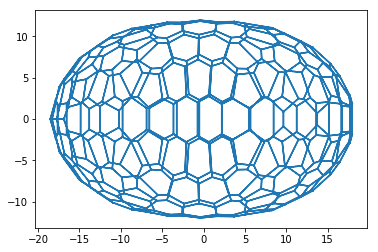

In [9]:
solver_kw = {'minimize': {'method': 'L-BFGS-B',
                          'options': {'ftol': 1e-8,
                                      'gtol': 1e-8}}}

res = Solver.find_energy_min(sheet, geom, model, **solver_kw)
res.fun
print(res.message)
fig, ax = sheet_view(sheet, coords=list('zx'), mode='quick')

In [10]:
ipv.clear()
ipv_fig, meshes = sheet_view(sheet, coords=list('zxy'),
                             mode='3D', **draw_specs(sheet))

ipv_fig

Figure(camera_center=[0.0, 0.0, 0.0], height=500, matrix_projection=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], matrix_world=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], meshes=[Mesh(color=array([[0.177423, 0.437527, 0.557565],
       [0.177423, 0.437527, 0.557565],
       [0.255645, 0.260703, 0.528312],
       ...,
       [0.162142, 0.474838, 0.55814 ],
       [0.229739, 0.322361, 0.545706],
       [0.201239, 0.38367 , 0.554294]]), lines=array([[  0,  75],
       [189,  89],
       [266, 269],
       ...,
       [  4,  67],
       [152, 151],
       [197, 196]], dtype=uint32), texture=None, x=array([  1.60481802,   1.60481802, -12.75042732, -12.75042732,
        12.88260389,  11.86798458, -14.5943082 , -14.16093407,
        12.10261254,  13.3562585 ,  13.73372411,  12.10261254,
        13.3562585 ,  13.73372411, -12.0777867 , -13.4568623 ,
       -17.44121313, -12.0777867 , -13.4568623 , -15.92969299,
       -15.22506097, -15.84728171, -15.92969299, -17.85680085,
       -17.23114135, -15.22506097, -15.84728171,  -8.65393742,
       -13.88856273, -16.83740681,  -8.33370968,  -5.914539  ,
        -6.45547437, -10.51458693,  -9.58139901,  -8.65393742,
       -13.88856273, -16.83740681,  -8.33370968,  -5.914539  ,
        -6.45547437, -10.51458693,  -9.58139901, -14.16093407,
       -14.5943082 ,   3.48421041,  10.95912689, -12.51988221,
       -12.51988221, -14.84972996, -13.95010305, -14.84972996,
       -13.95010305,   3.48421041,  10.95912689,  12.48158698,
        -9.86546886, -11.02029911, -10.72728216,  -9.77973061,
         5.48694384,   9.85717285,  12.88260389,  11.86798458,
        12.48158698,  11.25406865,   8.46713203,  11.25406865,
         9.50657454,  -0.71781424,  -3.62809586,  -0.71781424,
        -2.07756832,  -5.51846595,   4.26414494,   1.27851045,
         3.10452211,  17.73209471,  16.67379399,  -0.37656191,
        -4.1387738 ,  -0.38935275,  -2.51896714,  -0.5292273 ,
         2.61209746,  -0.37656191,  -4.1387738 ,  -0.38935275,
        -2.51896714,  -0.5292273 ,   2.61209746,  -8.72649597,
         2.26212331,   2.26212331,  -1.78782076,  -0.50177577,
         0.75704293,  -2.04830529,  -0.54569942,   1.02636166,
        -3.24095427,  -3.24095427,  -1.78782076,  -0.50177577,
         0.75704293,  -2.04830529,  -0.54569942,   1.02636166,
        16.6861743 ,  17.77264719,  16.6861743 ,  17.77264719,
        17.96793815,  11.68582517,   7.02521279,   6.9711803 ,
        11.68582517,   7.02521279,   6.9711803 ,  15.51406128,
        14.04558606,  16.52788949,  15.18255483,  15.51406128,
        14.04558606,  16.52788949,  15.18255483, -17.85680085,
       -18.50987089, -17.23114135, -17.44121313, -18.29551923,
       -17.62754177, -16.53900158, -17.62754177, -16.53900158,
       -10.98911758, -11.39332301, -12.81085444, -14.65879807,
       -15.04409315, -13.69029521,  -9.78129012, -15.82392589,
       -15.91274996, -16.80982437, -16.35132913, -10.98911758,
       -11.39332301, -12.81085444, -14.65879807, -15.04409315,
       -13.69029521,  -9.78129012, -15.82392589, -15.91274996,
       -16.80982437, -16.35132913, -16.88665369, -17.71684847,
       -13.79775118, -10.21389871, -13.79775118, -12.23286076,
         4.93307076,   7.45402212,   5.23842264,   9.20146004,
         8.40896092,   1.56699139,   3.71266641,   4.37801668,
         3.34354919,   1.44715381,  12.72008987,   9.1686962 ,
        11.42501838, -10.72728216,  -9.77973061,  -7.92439205,
        -9.86546886, -11.02029911,   4.93307076,   7.45402212,
         9.20146004,   1.56699139,   3.71266641,   4.37801668,
         3.34354919,   1.44715381,  12.72008987,   9.1686962 ,
        11.42501838,  -6.87892059,  -4.96954795,  -8.7661776 ,
         1.27851045,   3.10452211,   0.65131157,   2.20060603,
         3.5609509 ,   4.03339011,   0.89069262,   2.29150535,
         0.65131157,   2.20060603,   0.89069262,   2.29150535,
         8.59713471,   6.63294993,   8.40896092,

number of apoptotic cells: 26


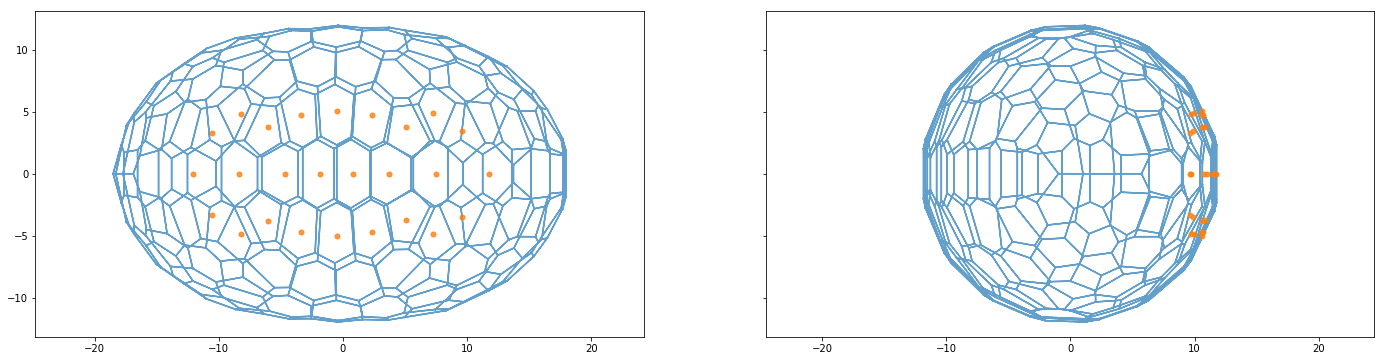

In [11]:
# Define ovoid mesoderm
define_mesoderm(sheet, a=15, b=6.)

mesoderm = sheet.face_df[sheet.face_df.is_mesoderm].index
delaminating_cells = sheet.face_df[sheet.face_df['is_mesoderm']].index
sheet.face_df['is_relaxation'] = False
print('number of apoptotic cells: {}'.format(delaminating_cells.size))
fig, axes = mesoderm_position(sheet, delaminating_cells)

In [12]:
from ipywidgets import IntProgress
from IPython.display import display

In [13]:
progress = IntProgress(min=0, max=40)
from tyssue.behaviors.sheet.delamination_events import constriction

def run_sim(sheet, mesoderm, geom, model, dirname, progress, stop=40):
    progress.stop=40
   
    display(progress)
    delaminating_cells = []
    #Initiate manager
    manager = EventManager('face', logfile='manager_log.txt')
    sheet.face_df['enter_in_process'] = 0    
    # Add all cells in constriction process 
    for f in sheet.face_df[sheet.face_df['is_mesoderm']].index :
        x = sheet.face_df.loc[f, 'x']
        c_rate = 1+(1.32-1) * ((1+np.exp(-0.19*25))/
                                          (1+np.exp(0.19*(abs(x)-25))))


        delam_kwargs = sheet.settings["delamination"].copy()
        delam_kwargs.update(
            {
                'face_id':f,
                'contract_rate': c_rate,
                'current_traction': 0,
                'max_traction':30
            }
        )
        manager.append(constriction, **delam_kwargs)
    
    while manager.current and manager.clock < stop:
        print(manager.clock)
        # Clean radial tension on all vertices
        sheet.vert_df['radial_tension'] = 0
        manager.execute(sheet)
        res = Solver.find_energy_min(sheet, geom, model, **solver_kw)
        
        # Save result in each time step.
        figname = os.path.join(
            dirname, 'invagination_{:04d}.png'.format(manager.clock))
        hdfname = figname[:-3] + 'hf5'
        hdf5.save_datasets(hdfname, sheet)
        
        

        manager.update()
        manager.clock += 1
        progress.value = manager.clock
    
    progress.stop = manager.clock
    return sheet

In [14]:

contractility_rate = 2
critical_area = 5
radial_tension = 60

# Directory definition 
dirname = '{}_contractility_{}_critical_area_{}_radialtension'.format(
            contractility_rate, critical_area, radial_tension)
dirname = os.path.join(sim_save_dir, dirname)

print('starting {}'.format(dirname))
try:
    os.mkdir(dirname)
except IOError:
    pass

settings = {'contract_rate': contractility_rate,
            'critical_area': critical_area,
            'radial_tension': radial_tension,
            'nb_iteration': 10,
            'contract_neighbors':True,
            'contract_span':1,
            'geom': geom}


# Add some information to the sheet
sheet.face_df['id'] = sheet.face_df.index.values
sheet.settings['delamination'] = settings

sheet = run_sim(sheet, delaminating_cells, 
                 geom, model, dirname, progress)

print('{} done'.format(dirname))
print('~~~~~~~~~~~~~~~~~~~~~\n')
    

starting /home/admin-suz/Documents/Simulations/2019-05-17_smallellipsoid/2_contractility_5_critical_area_60_radialtension


IntProgress(value=0, max=40)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
/home/admin-suz/Documents/Simulations/2019-05-17_smallellipsoid/2_contractility_5_critical_area_60_radialtension done
~~~~~~~~~~~~~~~~~~~~~



In [15]:
ls

ablation.csv                 Simulations_FiguresPrincipale.ipynb
Index.ipynb                  Simulations_GaussianWidthTest.ipynb
manager_log.txt              Simulations_YolkElasticity.ipynb
Simulations_Ablations.ipynb  SmallEllipsoidInvagination.ipynb


In [16]:
hfs = [f  for f in os.listdir(dirname) if f.endswith('hf5')]
hfs.sort()
from tyssue.draw.ipv_draw import edge_mesh, face_mesh

def get_meshes(dirname, hdf_file):
    dsets = hdf5.load_datasets(os.path.join(dirname, hdf_file),
                               data_names=['vert', 'edge', 'face'])
        
    sheet = Sheet('ellipse', dsets)
    faces = face_mesh(sheet, coords=['x', 'y', 'z'],
                      color=sheet.face_df['area'],
                      color_range=(0, 30))
    
    edges = edge_mesh(sheet, coords=['x', 'y', 'z'],
                      color=sheet.vert_df.y)
    return faces, edges

from ipywidgets import interact

def browse_sheets(dirname, hfs):
    n = len(hfs)
    ipv.clear()
    fig = ipv.gcf()
    meshes = get_meshes(dirname, hfs[0])
    fig.meshes = fig.meshes + list(meshes)
    
    def view_sheet(i):
        fig.animation = 0

        faces, edges = get_meshes(dirname, hfs[i])
        print()
        fig.meshes[0].x = faces.x
        fig.meshes[0].y = faces.y
        fig.meshes[0].z = faces.z
        fig.meshes[0].color = faces.color
        fig.meshes[0].triangles = faces.triangles

        fig.meshes[1].x = edges.x
        fig.meshes[1].y = edges.y
        fig.meshes[1].z = edges.z
        fig.meshes[1].color = edges.color
        fig.meshes[1].lines = edges.lines

        lim_inf = sheet.vert_df[sheet.coords].min().min()
        lim_sup = sheet.vert_df[sheet.coords].max().max()
        ipv.xyzlim(lim_inf, lim_sup)
    ipv.show()
    interact(view_sheet, i=(0, n-1))


In [17]:
browse_sheets(dirname, hfs)

VBox(children=(Figure(camera_center=[0.0, 0.0, 0.0], height=500, matrix_projection=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], matrix_world=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], meshes=[Mesh(color=array([[0.122312, 0.633153, 0.530398],
       [0.120081, 0.622161, 0.534946],
       [0.126326, 0.644107, 0.525311],
       ...,
       [0.159194, 0.482237, 0.558073],
       [0.139147, 0.533812, 0.555298],
       [0.122312, 0.633153, 0.530398]]), texture=None, triangles=array([[   0,  184, 1272],
       [  99,  185, 1273],
       [  98,  186, 1274],
       ...,
       [  13, 1269, 2357],
       [  52, 1270, 2358],
       [   3, 1271, 2359]], dtype=uint32), x=array([-10.41527363, -10.84188183, -11.73724886, ...,   1.56079728,
         7.26946421,  10.23306914]), y=array([-5.12516347, -4.6277878 , -0.51202361, ..., -9.92752384,
        0.75444549, -6.22948239]), z=array([  3.41937439,  -0.48971889,   1.60559834, ...,  11.25334123,
       -15.03656783,   1.28247174])), Mesh(color=array([[0.177423, 0.437527, 0.557565],
       [0.177423, 0.437527, 0.557565],
       [0.255645, 0.260703, 0.528312],
       ...,
       [0.162142, 0.474838, 0.55814 ],
       [0.229739, 0.322361, 0.545706],
       [0.201239, 0.38367 , 0.554294]]), lines=array([[  0,  75],
       [189,  89],
       [266, 269],
       ...,
       [  4,  67],
       [152, 151],
       [197, 196]], dtype=uint32), texture=None, x=array([-1.15262248e+01,  1.15262248e+01, -5.74425864e+00,  5.74425864e+00,
        2.58615032e+00,  5.65037594e+00,  1.94851982e+00,  4.82593713e+00,
       -2.43109893e+00, -5.31481165e+00, -7.10114911e-01,  2.43109893e+00,
        5.31481165e+00,  7.10114911e-01, -8.64058247e+00, -6.62547076e+00,
       -3.88410243e+00,  8.64058247e+00,  6.62547076e+00,  2.65310910e+00,
        5.46866390e+00,  5.79084809e+00, -2.65310910e+00, -2.31893468e+00,
       -4.13043357e+00, -5.46866390e+00, -5.79084809e+00, -1.09239570e+01,
       -7.46407028e+00, -4.83546910e+00, -1.08399228e+01, -1.10609088e+01,
       -9.92978755e+00, -9.31891033e+00, -8.97091311e+00,  1.09239570e+01,
        7.46407028e+00,  4.83546910e+00,  1.08399228e+01,  1.10609088e+01,
        9.92978755e+00,  9.31891033e+00,  8.97091311e+00, -4.82593713e+00,
       -1.94851982e+00, -1.16088396e+01, -8.66562838e+00, -1.54199337e+00,
        1.54199337e+00, -1.95026187e+00, -2.60259960e+00,  1.95026187e+00,
        2.60259960e+00,  1.16088396e+01,  8.66562838e+00,  6.56239358e+00,
        7.03397377e+00,  5.97432974e+00,  2.72889086e+00,  2.17026874e+00,
       -1.30114255e+00,  5.86237935e+00, -2.58615032e+00, -5.65037594e+00,
       -6.56239358e+00, -1.56079728e+00,  2.14065357e+00,  1.56079728e+00,
        2.73231350e+00, -2.01938637e+00,  1.81607313e+00,  2.01938637e+00,
        2.76541806e+00, -9.17758363e+00, -9.20692053e+00, -1.02330691e+01,
       -9.18898249e+00, -1.59620288e+00, -2.04154970e+00, -1.19406100e+01,
       -1.15420309e+01, -1.18319903e+01, -1.14818418e+01, -1.01945583e+01,
       -7.44893530e+00,  1.19406100e+01,  1.15420309e+01,  1.18319903e+01,
        1.14818418e+01,  1.01945583e+01,  7.44893530e+00,  2.63541812e+00,
       -2.08677583e+00,  2.08677583e+00, -3.01106647e+00, -2.31810997e+00,
       -3.00267983e+00, -7.02292484e+00, -7.80274680e+00, -7.00599254e+00,
       -2.11824068e+00,  2.11824068e+00,  3.01106647e+00,  2.31810997e+00,
        3.00267983e+00,  7.02292484e+00,  7.80274680e+00,  7.00599254e+00,
       -1.59368673e+00, -1.48725304e+00,  1.59368673e+00,  1.48725304e+00,
       -1.84963353e+00, -6.87377180e+00, -7.29612011e+00, -8.40034105e+00,
        6.87377180e+00,  7.29612011e+00,  8.40034105e+00, -5.07185096e+00,
       -5.06819009e+00, -1.84910327e+00, -2.00788309e+00,  5.07185096e+00,
        5.06819009e+00,  1.84910327e+00,  2.00788309e+00,  2.31893468e+00,
        1.75375160e-13,  4.13043357e+00,  3.88410243e+00, -4.25091092e-14,
       -1.73430943e+00, -1.91269381e+00,  1.7

interactive(children=(IntSlider(value=19, description='i', max=39), Output()), _dom_classes=('widget-interact',))

In [18]:
current = 'invagination_0007.hf5'
ipv.clear()
ipv.style.use('dark')


dsets = hdf5.load_datasets(os.path.join(dirname, current),
                               data_names=['vert', 'edge', 'face'])

specs = config.geometry.cylindrical_sheet()
sheet = Sheet('ellipse', dsets, specs)
